In [ ]:
import sys
import comet_ml
import torch

import numpy as np

from sklearn.metrics import (
    f1_score, confusion_matrix, classification_report,
    balanced_accuracy_score, accuracy_score,
)
# from transformers.integrations import CometCallback

sys.path.append('..')
from lib.utils import set_seed, get_device
from lib.utils.constants import RANDOM_SEED
from lib.data.loading import pd_read_jsonl_file

In [2]:
# import os
# from dotenv import load_dotenv

# load_dotenv()

# comet_api_key = os.getenv("COMET_API_KEY")
# os.environ["CUDA_VISIBLE_DEVICES"]="0,1"

In [12]:
import torch

torch.cuda.empty_cache()

In [3]:
set_seed(RANDOM_SEED)

DEVICE = get_device()
print(f'Using device: {DEVICE}')

Using device: cuda


In [4]:
df_en_train = pd_read_jsonl_file('../data/en_train.jsonl')
df_en_dev = pd_read_jsonl_file('../data/en_dev.jsonl')
df_en_test = pd_read_jsonl_file('../data/en_devtest_text_id_only.jsonl')

In [5]:
df_en_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 610767 entries, 0 to 610766
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   id          610767 non-null  object
 1   source      610767 non-null  object
 2   sub_source  610767 non-null  object
 3   lang        610767 non-null  object
 4   model       610767 non-null  object
 5   label       610767 non-null  int64 
 6   text        610767 non-null  object
dtypes: int64(1), object(6)
memory usage: 32.6+ MB


In [6]:
df_en_train.head()

,id,source,sub_source,lang,model,label,text
0,f05034ca-d1da-445d-a6a2-5869ade0dfc3,m4gt,reddit,en,llama3-8b,1,Hitler's plans for the succession and power st...
1,e7d7fe23-3709-4e14-aa2d-d76821dcbdf6,mage,squad,en,human,0,The Bush administration then turned its attent...
2,1a68d42e-4202-4e36-bceb-02d693440a14,mage,yelp,en,human,0,Really really the best pedi ever! Pho was so a...
3,5de844ab-c197-4378-b144-c3a46e3f5b67,mage,xsum,en,human,0,The PS42m MV Loch Seaforth made its first pass...
4,cdf050ad-7d90-4235-b7c6-46ca6cfc4382,m4gt,wikipedia,en,human,0,Malta participated in the Eurovision Song Cont...


In [7]:
MODEL_NAME = "facebook/xlm-roberta-xl"

In [8]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

In [12]:
# Count the number of tokens in each sentence
df_en_train['num_tokens'] = df_en_train['text'].apply(lambda x: len(tokenizer(x)['input_ids']))
df_en_dev['num_tokens'] = df_en_dev['text'].apply(lambda x: len(tokenizer(x)['input_ids']))
df_en_test['num_tokens'] = df_en_test['text'].apply(lambda x: len(tokenizer(x)['input_ids']))

In [13]:
df_en_train['num_tokens'].describe()

count    610767.000000
mean        349.455526
std         344.300951
min           3.000000
25%         125.000000
50%         271.000000
75%         455.000000
max        6057.000000
Name: num_tokens, dtype: float64

In [32]:
df_en_dev['num_tokens'].describe()

count    261758.000000
mean        349.854977
std         344.408232
min           3.000000
25%         125.000000
50%         271.000000
75%         456.000000
max        5826.000000
Name: num_tokens, dtype: float64

In [33]:
df_en_test['num_tokens'].describe()

count    32557.000000
mean       489.014283
std        400.193016
min         10.000000
25%        285.000000
50%        383.000000
75%        571.000000
max      20010.000000
Name: num_tokens, dtype: float64

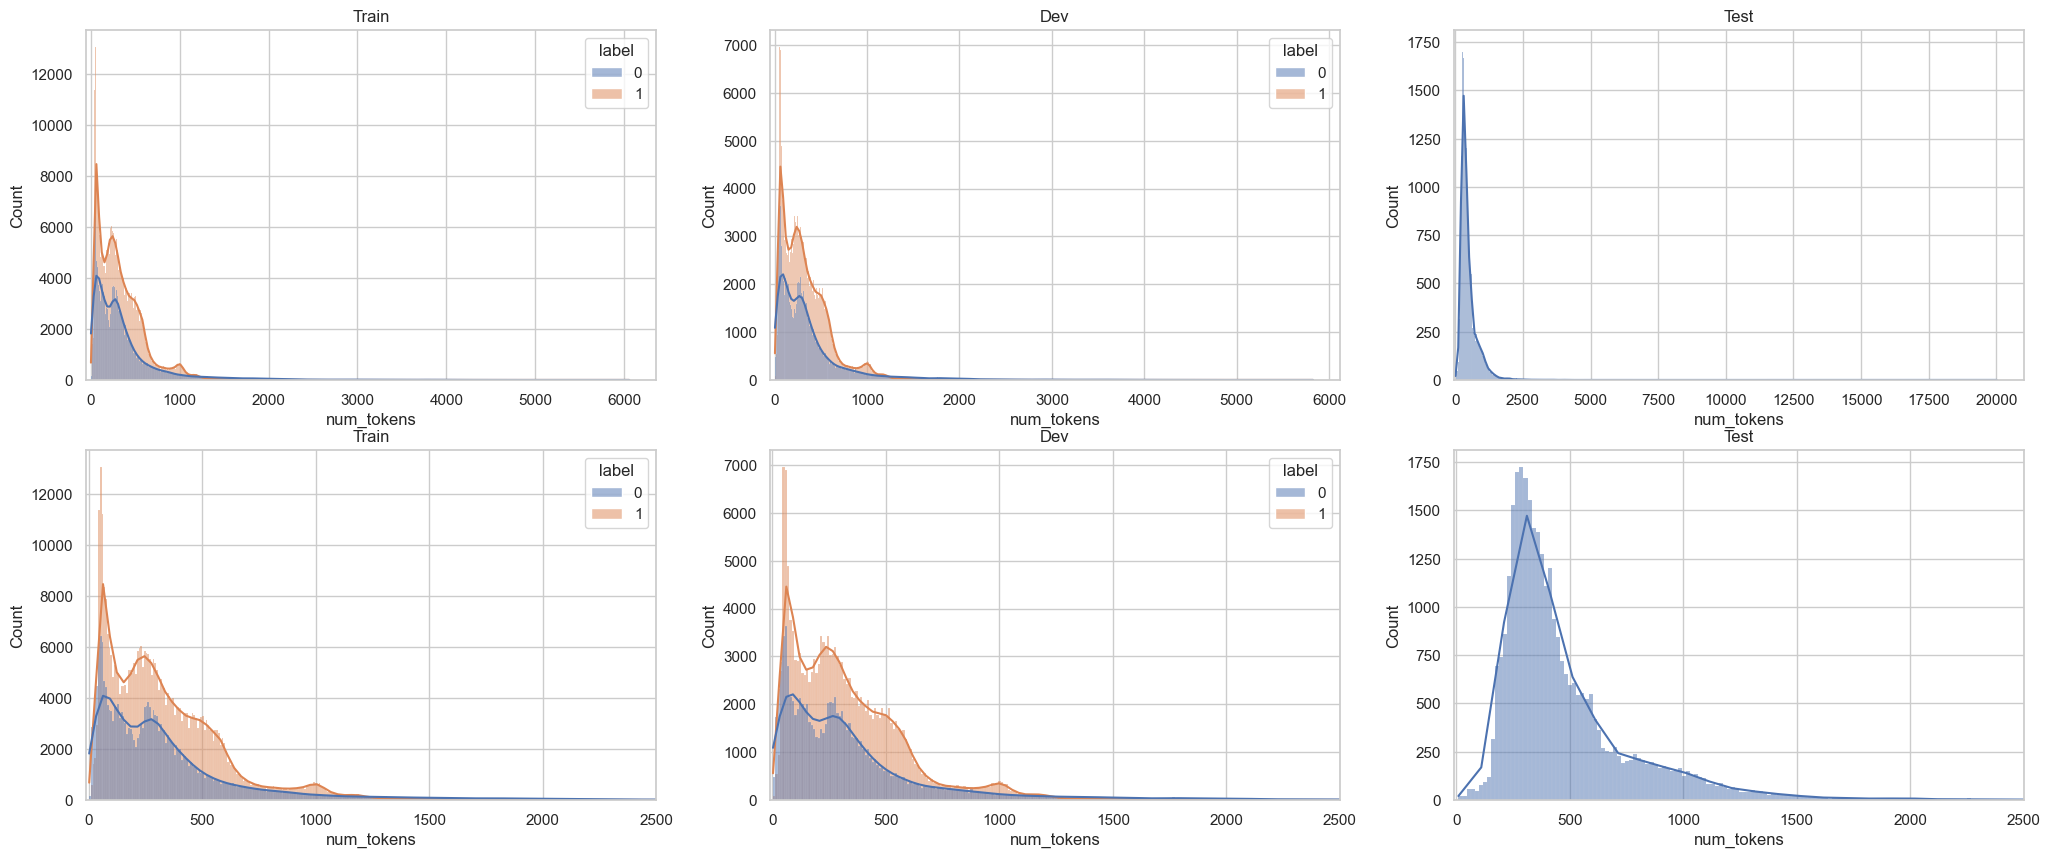

In [58]:
# Create a distribution plot over the number of tokens grouped by dataset and label
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

fig, ax = plt.subplots(2, 3, figsize=(25, 10))

sns.histplot(df_en_train, x='num_tokens', hue='label', kde=True, ax=ax[0][0])
sns.histplot(df_en_dev, x='num_tokens', hue='label', kde=True, ax=ax[0][1])
sns.histplot(df_en_test, x='num_tokens', kde=True, ax=ax[0][2])

sns.histplot(df_en_train, x='num_tokens', hue='label', kde=True, ax=ax[1][0])
sns.histplot(df_en_dev, x='num_tokens', hue='label', kde=True, ax=ax[1][1])
sns.histplot(df_en_test, x='num_tokens', kde=True, ax=ax[1][2])

ax[0][0].set_title('Train')
ax[0][0].set_xlim(left=-50)
ax[0][1].set_title('Dev')
ax[0][1].set_xlim(left=-50)
ax[0][2].set_title('Test')
ax[0][2].set_xlim(left=-50)

ax[1][0].set_title('Train')
ax[1][0].set_xlim(left=-10, right=2500)
ax[1][1].set_title('Dev')
ax[1][1].set_xlim(left=-10, right=2500)
ax[1][2].set_title('Test')
ax[1][2].set_xlim(left=-10, right=2500)

plt.show()

# Load model

In [13]:
MODEL_NAME = "distilbert/distilbert-base-cased"

In [14]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)

Some weights of the model checkpoint at distilbert/distilbert-base-cased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-cased and are newly initialized: ['pre_classifier.bias', 'classifier.weight', 'pre_classifier.wei

In [15]:
model

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [16]:
for param in model.parameters():
    param.requires_grad = False

for param in model.distilbert.transformer.layer[-1].parameters():
    param.requires_grad = True

for param in model.classifier.parameters():
    param.requires_grad = True

In [17]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)

distilbert.transformer.layer.5.attention.q_lin.weight
distilbert.transformer.layer.5.attention.q_lin.bias
distilbert.transformer.layer.5.attention.k_lin.weight
distilbert.transformer.layer.5.attention.k_lin.bias
distilbert.transformer.layer.5.attention.v_lin.weight
distilbert.transformer.layer.5.attention.v_lin.bias
distilbert.transformer.layer.5.attention.out_lin.weight
distilbert.transformer.layer.5.attention.out_lin.bias
distilbert.transformer.layer.5.sa_layer_norm.weight
distilbert.transformer.layer.5.sa_layer_norm.bias
distilbert.transformer.layer.5.ffn.lin1.weight
distilbert.transformer.layer.5.ffn.lin1.bias
distilbert.transformer.layer.5.ffn.lin2.weight
distilbert.transformer.layer.5.ffn.lin2.bias
distilbert.transformer.layer.5.output_layer_norm.weight
distilbert.transformer.layer.5.output_layer_norm.bias
classifier.weight
classifier.bias


In [18]:
def get_num_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


trainable_params = get_num_parameters(model)
print(f'Trainable parameters: {trainable_params} ({trainable_params / model.num_parameters():.2%})')

Trainable parameters: 7089410 (10.78%)


# Measure performance before training/fine-tuning the model

In [11]:
import torch

from tqdm import tqdm


def get_performance_metrics(y_true, y_pred):
    f1 = f1_score(y_true, y_pred, average='macro')
    acc = accuracy_score(y_true, y_pred)
    bal_acc = balanced_accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    cr = classification_report(y_true, y_pred)

    return {
        'f1': f1,
        'accuracy': acc,
        'balanced_accuracy': bal_acc,
        'confusion_matrix': cm,
        'classification_report': cr
    }


def measure_initial_performance(model, tokenizer, df_test, device, max_length=512, batch_size=32):
    model.to(device)
    model.eval()

    test_samples = df_test.text.tolist()

    outputs = []
    for i in tqdm(range(0, len(test_samples), batch_size)):
        batch = test_samples[i:i + batch_size]
        inputs = tokenizer(
            batch,
            padding=True,
            truncation=True,
            max_length=max_length,
            return_tensors='pt'
        )
        inputs = {k: v.to(device) for k, v in inputs.items()}

        with torch.no_grad():
            output = model(**inputs)
            outputs.append(output.logits)

    outputs = torch.cat(outputs, dim=0)
    predictions = torch.argmax(outputs, dim=1).cpu().numpy()

    performance = get_performance_metrics(df_test.label, predictions)
    return performance


initial_performance = measure_initial_performance(model, tokenizer, df_en_dev, DEVICE)
initial_performance

100%|██████████| 8180/8180 [08:46<00:00, 15.53it/s]


{'f1': 0.38856221156147674,
 'accuracy': 0.6211347886215512,
 'balanced_accuracy': 0.498585638605751,
 'confusion_matrix': array([[   575,  97753],
        [  1418, 162012]]),
 'classification_report': '              precision    recall  f1-score   support\n\n           0       0.29      0.01      0.01     98328\n           1       0.62      0.99      0.77    163430\n\n    accuracy                           0.62    261758\n   macro avg       0.46      0.50      0.39    261758\nweighted avg       0.50      0.62      0.48    261758\n'}

In [11]:
def test_samples(model, tokenizer, df, device, max_length=512):
    model.to(device)
    model.eval()

    test_samples = df.text.tolist()[:5]
    inputs = tokenizer(
        test_samples,
        padding=True,
        truncation=True,
        max_length=max_length,
        return_tensors='pt'
    )
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs).logits

    # print(outputs.shape)
    print(outputs)

In [12]:
test_samples(model, tokenizer, df_en_train, DEVICE)

tensor([[-0.0314,  0.0181],
        [-0.0319,  0.0190],
        [-0.0338,  0.0227],
        [-0.0318,  0.0197],
        [-0.0323,  0.0195]], device='cuda:0')


# Fine-tune the model

In [19]:
class_weights = (
    1 / df_en_train.label.value_counts(normalize=True).sort_index()
).tolist()
class_weights = torch.tensor(class_weights)
class_weights = class_weights / class_weights.sum()

class_weights

tensor([0.6252, 0.3748])

In [20]:
from datasets import Dataset, DatasetDict

ds_train = Dataset.from_pandas(df_en_train)
ds_dev = Dataset.from_pandas(df_en_dev)
ds_test = Dataset.from_pandas(df_en_test)

In [21]:
ds_train

Dataset({
    features: ['id', 'source', 'sub_source', 'lang', 'model', 'label', 'text'],
    num_rows: 610767
})

In [22]:
ds_train_shuffled = ds_train.shuffle(seed=RANDOM_SEED)

In [23]:
dataset = DatasetDict({
    'train': ds_train_shuffled,
    'dev': ds_dev,
    'test': ds_test
})

In [24]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'source', 'sub_source', 'lang', 'model', 'label', 'text'],
        num_rows: 610767
    })
    dev: Dataset({
        features: ['id', 'source', 'sub_source', 'lang', 'model', 'label', 'text'],
        num_rows: 261758
    })
    test: Dataset({
        features: ['id', 'text'],
        num_rows: 32557
    })
})

In [25]:
MAX_LEN = 512
# col_to_delete = ['source', 'sub_source', 'lang', 'model']


def preprocess_dataset(ds):
    return tokenizer(ds['text'], truncation=True, max_length=MAX_LEN)


tokenized_datasets = dataset.map(preprocess_dataset, batched=True)
tokenized_datasets.set_format("torch")
     

Map:   0%|          | 0/610767 [00:00<?, ? examples/s]

Map:   0%|          | 0/261758 [00:00<?, ? examples/s]

Map:   0%|          | 0/32557 [00:00<?, ? examples/s]

In [26]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['id', 'source', 'sub_source', 'lang', 'model', 'label', 'text', 'input_ids', 'attention_mask'],
        num_rows: 610767
    })
    dev: Dataset({
        features: ['id', 'source', 'sub_source', 'lang', 'model', 'label', 'text', 'input_ids', 'attention_mask'],
        num_rows: 261758
    })
    test: Dataset({
        features: ['id', 'text', 'input_ids', 'attention_mask'],
        num_rows: 32557
    })
})

In [27]:
from transformers import DataCollatorWithPadding

collate_fn = DataCollatorWithPadding(tokenizer=tokenizer)

In [28]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    return {
        'macro_f1': f1_score(predictions, labels, average='macro'),
        'accuracy': accuracy_score(predictions,labels),
        'balanced_accuracy': balanced_accuracy_score(predictions, labels),
    }

In [29]:
import torch
import torch.nn.functional as F

from transformers import Trainer


class WeightedCrossEntropyTrainer(Trainer):
    def __init__(self, *args, class_weights=None, **kwargs):
        super().__init__(*args, **kwargs)
        if class_weights is not None:
            self.class_weights = torch.tensor(
                class_weights, dtype=torch.float32
        ).to(self.args.device)
        else:
            self.class_weights = None

    def compute_loss(self, model, inputs, return_outputs=False):
        # Extract labels and convert them to long type for cross_entropy
        labels = inputs.pop("labels").long()

        # Forward pass
        outputs = model(**inputs)

        # Extract logits assuming they are directly outputted by the model
        logits = outputs.get('logits')

        # Compute custom loss with class weights for imbalanced data handling
        if self.class_weights is not None:
            loss = F.cross_entropy(logits, labels, weight=self.class_weights)
        else:
            loss = F.cross_entropy(logits, labels)

        return (loss, outputs) if return_outputs else loss

In [22]:
# from comet_ml import Experiment
# from comet_ml.integration.pytorch import log_model

# experiment = Experiment(
#     api_key=comet_api_key,
#     project_name="mgt-detection-coling-2025",
#     workspace="unibuc-phd",
# )

In [30]:
params = {
    "learning_rate": 2e-4,
    "num_train_epochs": 2,
    "weight_decay": 1e-2,
    "seed": RANDOM_SEED,
}

# experiment.log_parameters(params)

In [31]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir='../results',
    learning_rate=params["learning_rate"],
    per_device_train_batch_size=32,
    per_device_eval_batch_size=16,
    num_train_epochs=params["num_train_epochs"],
    weight_decay=params["weight_decay"],
    evaluation_strategy='epoch',
    save_strategy='epoch',
    load_best_model_at_end=True,
    # report_to="comet_ml",
    seed=params["seed"],
)

In [32]:
trainer = WeightedCrossEntropyTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['dev'],
    tokenizer=tokenizer,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    class_weights=class_weights,
    # callbacks=[CometCallback()],
)

/tmp/ipykernel_10714/3314886341.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.class_weights = torch.tensor(


In [33]:
train_result = trainer.train()

/root/.conda/envs/pytorch/lib/python3.11/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Macro F1,Accuracy,Balanced Accuracy
1,0.152700,0.274004,0.909858,0.917825,0.925741
2,0.103700,0.208154,0.933510,0.938821,0.943946


In [35]:
metrics = train_result.metrics
max_train_samples = len(ds_train)
metrics["train_samples"] = min(max_train_samples, len(ds_train))
trainer.log_metrics("train", metrics)
trainer.save_metrics("train", metrics)
trainer.save_state()

***** train metrics *****
  epoch                    =         2.0
  total_flos               = 150680484GF
  train_loss               =      0.1619
  train_runtime            =  1:22:25.98
  train_samples            =      610767
  train_samples_per_second =     246.975
  train_steps_per_second   =       7.718


In [38]:
trainer.save_model("saved_model")

In [58]:
tokenized_datasets['test']['input_ids'][:3]

[tensor([  101,  1188,  1763,  2370,  1144,  1151,  5540,  9684,  2798, 10228,
           119,  1422,  3547,  1575,  1117,  2261,  1177,   146,  1138,  1125,
          1106,  1619,  1366,   119,  1599,  1117,  1610,  1400,  2423, 20580,
          1105,  1470,  6312,  1107,  1103,  1331,  1195,  1686,  1107,  1110,
         26641,   117,  1177,  1256,  1191,  1119,  1458,  1106,  1243,   170,
          2261,  1119,  2010,   787,   189,  1129,  1682,  1106,  1243,  1213,
           119,  1247,   787,   188,  1185,  1907,  1250,  1121,  1313,  5448,
          1719,  1105,   146,  4031,  3828,   119,  1135,  4692,   170,  1974,
          1106,  8239,  1103,  1610,   117,  1105,  1122,  1145,  4692,   170,
          1974,  1106,  4417,   170,  1610,   119,  1370,  1103,  1763,  1160,
          2277,  1195,  1138,  1151,  1177,  2795,  1105,  2869,  1195,  1577,
           787,   189,  1256,  3940,   119,   146,  1921,  1400,  3004,  8128,
          1105,  1195,  3004, 10020,  1105,  1400,  

In [66]:
tokenizer(df_en_test[:3].text.tolist(), truncation=True, padding=True, max_length=512, return_tensors="pt")

{'input_ids': tensor([[  101,  1188,  1763,  ...,  1142,   119,   102],
        [  101,  1192,  1221,  ...,     0,     0,     0],
        [  101,  9954, 18778,  ...,     0,     0,     0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}

In [70]:
import pandas as pd
from tqdm import tqdm


def make_predictions(model, tokenizer, df, device, file_path, max_len=MAX_LEN, batch_size=16):
    model.eval()

    all_ids = []
    all_predictions = []
    with torch.no_grad():
        for i in tqdm(range(0, len(df), batch_size)):
            ids = df[i:i + batch_size].id.tolist()
            texts = df[i:i + batch_size].text.tolist()

            inputs = tokenizer(texts, truncation=True, padding=True, max_length=max_len, return_tensors="pt")
            
            input_ids = inputs['input_ids'].to(device)
            attention_mask = inputs['attention_mask'].to(device)

            outputs = model(input_ids, attention_mask).logits
            preds = torch.argmax(outputs, dim=1).cpu().numpy()

            all_ids.extend(ids)
            all_predictions.extend(preds)

    df_predictions = pd.DataFrame({
        "id": all_ids,
        "label": all_predictions,
    })

    df_predictions.to_json(
        file_path,
        orient="records",
        lines=True,
    )

    return df_predictions
    

In [71]:
df_test_predictions = make_predictions(
    trainer.model,
    tokenizer,
    df_en_test,
    DEVICE,
    "./subtask_a.jsonl",
)

100%|██████████| 2035/2035 [01:46<00:00, 19.14it/s]


In [77]:
df_en_train.label.value_counts(normalize=True)

label
1    0.625189
0    0.374811
Name: proportion, dtype: float64

In [79]:
df_en_dev.label.value_counts(normalize=True)

label
1    0.624355
0    0.375645
Name: proportion, dtype: float64

In [76]:
df_test_predictions.label.value_counts(normalize=True)

label
1    0.720859
0    0.279141
Name: proportion, dtype: float64

In [48]:
# experiment.end()